# Learning a Direct Acyclic Graph (DAG) on Data

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cooper-org/cooper/blob/master/docs/source/notebooks/plot_dag_learning.ipynb)


Consider the problem of learning a Directed Acyclic Graph (DAG) on data. This is a common problem in causal inference, where we are interested in learning the causal relationships between variables. In this notebook, we will demonstrate how to learn a DAG on data using a {py:class}`~cooper.formulations.QuadraticPenalty` formulation in **Cooper**.


In [92]:
%%capture
# %pip install cooper-optim
%pip install --index-url https://test.pypi.org/simple/ --no-deps cooper-optim  # TODO: Remove this line when cooper deployed to pypi

In [93]:
import logging
import math

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from scipy.linalg import expm

import cooper

## Problem Formulation


Consider a $d$-dimensional random vector ${X_1, X_2, ..., X_d}$. Given $n$ observations of the random vector $X \in \mathbb{R}^{n \times d}$, we are interested in learning a DAG $G = (V, E)$ whose edges represent the dependencies between the variables. We model the DAG via an adjacency matrix $A \in \{0, 1\}^{d \times d}$, where $A_{ij} = 1$ if there is an edge from $X_i$ to $X_j$ and $A_{ij} = 0$ otherwise.

This problem can be formulated as the following optimization problem:
\begin{equation}
\min_{A \in \{0, 1\}^{d \times d}} \left\| X - XA \right\|_F^2 + \lambda \|A\|_1,
\quad s.t. \quad A \text{ is acyclic},
\end{equation}

where $\| \cdot \|_F$ is the Frobenius norm, $\lambda$ is a regularization parameter aimed at encougaing sparsity in the learned DAG, and the constraint ensures that the learned graph is acyclic.

{cite:t}`NOTEARS` show that the acyclicity constraint can be formulated as $\text{tr}(e^{A}) = d$, where $e^{A}$ is the matrix exponential of $A$. This yields the following optimization problem:

\begin{equation}
\min_{A \in \{0, 1\}^{d \times d}} \left\| X - XA \right\|_F^2 + \lambda \|A\|_1,
\quad s.t. \quad \text{tr}(e^{A}) = d.
\end{equation}

We will use the following autograd-compatible function to compute the matrix exponential:

In [94]:
class TrExpScipy(torch.autograd.Function):
    """autograd.Function to compute trace of an exponential of a matrix"""

    @staticmethod
    def forward(ctx, M):
        with torch.no_grad():
            expm_input = expm(M.detach().cpu().numpy())  # using scipy
            expm_input = torch.as_tensor(expm_input)

            if M.is_cuda:
                assert expm_input.is_cuda

            ctx.save_for_backward(expm_input)
            return torch.trace(expm_input)

    @staticmethod
    def backward(ctx, grad_output):
        with torch.no_grad():
            (expm_input,) = ctx.saved_tensors
            return expm_input.t() * grad_output

## Data Generation

The generative process we use is this:

$X_i \leftarrow \sum_{j \in \pi_i} X_j + \epsilon_i$

where $\pi_i$ is the set of parents of $X_i$, and $\epsilon_i$ is a noise term.

In [103]:
torch.manual_seed(0)
np.random.seed(0)


def generate_data(n: int, d: int, n_causes: int, noise_std: float, device: torch.device) -> torch.Tensor:
    """Generate data from a linear structural equation model with Gaussian noise.
    The

    Args:
        n: number of samples
        d: number of features
        n_causes: number of roots in the graph
        noise_std: standard deviation of the noise
        device: torch.device

    Returns:
        torch.Tensor: X of shape (n, d)
        torch.Tensor: A of shape (d, d)
    """
    assert n_causes <= d

    # --------------------------------------------
    # Generate the adjacency matrix
    # --------------------------------------------

    # Rows are nodes, columns are parents
    A = torch.zeros(d, d, device=device)

    for i in range(n_causes, d):
        parents = torch.randperm(i)[: np.random.randint(1, i)]
        A[i, parents] = 1

    assert TrExpScipy.apply(A).item() == d, "A is not a DAG"

    # --------------------------------------------
    # Sample data
    # --------------------------------------------

    noise = noise_std * torch.randn(n, d, device=device)
    X = torch.zeros(n, d, device=device)

    for i in range(d):
        parents = torch.nonzero(A[i]).flatten()
        X[:, i] = X[:, parents].sum(dim=1) + noise[:, i]

    # Improve conditioning
    X /= math.sqrt(d)

    return X, A

## Solving the Problem

We will use the {py:class}`~cooper.formulations.QuadraticPenalty` formulation to solve the problem. This leads to the following formulation of the constrained optimization problem:

\begin{equation}
\min_{A \in \{0, 1\}^{d \times d}} \left\| X - XA \right\|_F^2 + \lambda \|A\|_1 + \frac{c}{2}[\text{tr}(e^{A}) - d]^2,
\end{equation}

where $c$ is a penalty parameter. We will schedule the penalty parameter $c$ to increase over time in order to enforce the acyclicity constraint.

### Data

In [102]:
D = 10
N = 1000
N_CAUSES = 3
NOISE_STD = 1e-1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate data
X, A_TRUE = generate_data(N, D, N_CAUSES, NOISE_STD, DEVICE)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 1., 0.]])


### ConstrainedMinimizationProblem

In [97]:
class DAGLearning(cooper.ConstrainedMinimizationProblem):
    def __init__(self, X: torch.Tensor, lmbda: float):
        super().__init__()

        self.X = X
        self.n, self.d = X.shape
        self.lmbda = lmbda

        penalty_coefficient = cooper.penalty_coefficients.DensePenaltyCoefficient(
            init=torch.tensor(1.0, device=X.device),
        )
        self.constraint = cooper.Constraint(
            constraint_type=cooper.ConstraintType.EQUALITY,
            formulation_type=cooper.formulations.QuadraticPenalty,
            penalty_coefficient=penalty_coefficient,
        )

    def compute_cmp_state(self, A: torch.Tensor) -> cooper.CMPState:
        loss = torch.linalg.norm(self.X - self.X @ torch.sigmoid(A.T), ord="fro") ** 2
        loss += self.lmbda * torch.linalg.norm(torch.sigmoid(A), ord=1)

        constraint_value = TrExpScipy.apply(A) - self.d
        constraint_state = cooper.ConstraintState(violation=constraint_value)

        return cooper.CMPState(loss=loss, observed_constraints={self.constraint: constraint_state})

### Training

In [99]:
A = torch.nn.Parameter(torch.randn(D, D, device=DEVICE) / math.sqrt(D))

LMBDA = 1e-1
PRIMAL_LR = 1e-5
MOMENTUM = 0.9
N_STEPS = 1_000

cmp = DAGLearning(X, LMBDA)

primal_optimizer = torch.optim.SGD([A], lr=PRIMAL_LR, momentum=MOMENTUM)
constrained_optimizer = cooper.optim.UnconstrainedOptimizer(cmp=cmp, primal_optimizers=primal_optimizer)

# Multiply the penalty coefficient by `growth_factor` if the constraint is violated
# by more than `violation_tolerance`
penalty_scheduler = cooper.penalty_coefficients.MultiplicativePenaltyCoefficientUpdater(
    growth_factor=1.01,
    violation_tolerance=1e-4,
)

logger = logging.getLogger("cooper")
for i in range(N_STEPS):
    roll_out = constrained_optimizer.roll(compute_cmp_state_kwargs={"A": A})

    # Set the diagonal to zero to prevent self-loops
    A.data.fill_diagonal_(0)

    # Update the penalty coefficient
    constraint_state = roll_out.cmp_state.observed_constraints[cmp.constraint]
    penalty_scheduler.update_penalty_coefficient_(cmp.constraint, constraint_state)

    loss = roll_out.loss.item()
    violation = constraint_state.violation.item()
    primal_lagrangian = roll_out.primal_lagrangian_store.lagrangian.item()
    penalty_coefficient_value = cmp.constraint.penalty_coefficient()

    if i % (N_STEPS // 10) == 0:
        log = (
            f"Step {i}, loss={loss:.4f}, violation={violation:.4f}, penalty_coefficient={penalty_coefficient_value:.4f}"
        )
        logger.info(log)

final_log = f"Final loss: {loss:.4f}, violation: {violation:.4f}, penalty_coefficient: {penalty_coefficient_value:.4f}"
logger.info(final_log)

Step 0, loss=2201.7742, violation=0.5068, penalty_coefficient=1.0100
Step 100, loss=1128.9160, violation=0.0110, penalty_coefficient=2.7319
Step 200, loss=693.1588, violation=0.5280, penalty_coefficient=7.3892
Step 300, loss=505.0096, violation=0.2386, penalty_coefficient=19.9863
Step 400, loss=400.4205, violation=0.0640, penalty_coefficient=54.0591
Step 500, loss=333.4678, violation=0.0208, penalty_coefficient=146.2198
Step 600, loss=286.8203, violation=0.0070, penalty_coefficient=395.4971
Step 700, loss=252.3343, violation=0.0024, penalty_coefficient=1069.7448
Step 800, loss=225.7109, violation=0.0008, penalty_coefficient=2893.4583
Step 900, loss=204.4717, violation=0.0003, penalty_coefficient=7826.2573
Final loss: 787.2999, violation: 0.5077, penalty_coefficient: 20342.5723


### Results

In [109]:
def plot_adjacency(adjacency, gt_adjacency):
    """Plot side by side: 1)the learned adjacency matrix, 2)the ground truth adj
    matrix and 3)the difference of these matrices
    :param np.ndarray adjacency: learned adjacency matrix
    :param np.ndarray gt_adjacency: ground truth adjacency matrix
    :param str exp_path: path where to save the image
    :param str name: additional suffix to add to the image name
    """
    plt.clf()
    _, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1)

    kwargs = {"vmin": -1, "vmax": 1, "cmap": "Blues_r", "xticklabels": False, "yticklabels": False}
    sns.heatmap(adjacency, ax=ax2, cbar=False, **kwargs)
    sns.heatmap(gt_adjacency, ax=ax3, cbar=False, **kwargs)
    sns.heatmap(adjacency - gt_adjacency, ax=ax1, cbar=False, **kwargs)

    ax2.set_title("Learned")
    ax1.set_title("Learned - GT")
    ax3.set_title("Ground truth")

    ax1.set_aspect("equal", adjustable="box")
    ax2.set_aspect("equal", adjustable="box")
    ax3.set_aspect("equal", adjustable="box")

    plt.show()

<Figure size 640x480 with 0 Axes>

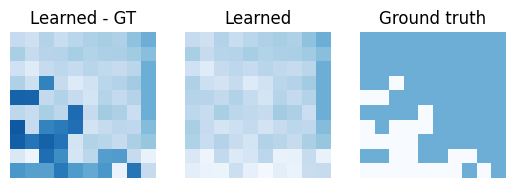

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 1., 0.]])


In [110]:
# Plot

ROUND_A = torch.where(torch.sigmoid(A) < 1e-1, torch.zeros_like(A), torch.sigmoid(A))
plot_adjacency(ROUND_A.cpu().detach().numpy(), A_TRUE.cpu().detach().numpy())

## References
- NOTEARS
- Seb's paper?
